In [2]:
#import all libraries if GPU is found
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else:
  gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)
  print('Found GPU at: {}'.format(device_name))
  import os                          
  import cv2                          
  import keras      
  import fnmatch                  
  import pandas as pd                
  import matplotlib.pyplot as plt     
  import numpy as np
  import re
  from keras.layers import Dense                                  
  from keras.layers import Input 
  from keras.layers import Conv2D
  from keras.layers import MaxPool2D
  from keras.layers import Flatten                                
  from keras import Model                                         
  from keras.models import Sequential                                   
  from keras import optimizers   
  from keras.preprocessing.image import ImageDataGenerator        
  from keras.preprocessing import image                           
  from tensorflow.keras.optimizers import Adam                    
  from tensorflow.keras.optimizers import RMSprop                 
  from keras.applications.vgg16 import VGG16                   
  from sklearn.model_selection import train_test_split 
  from sklearn.preprocessing import LabelBinarizer
  from keras.callbacks import ModelCheckpoint, EarlyStopping
  from roboflow import Roboflow
  from npy_append_array import NpyAppendArray

Found GPU at: /device:GPU:0


In [5]:
device_name = "culs"

In [6]:
dataset_name         = "224_full"    #"224_half", "224_full" "416_full", "416_half"
if (device_name == "culs"):
    project_dir = "C:/Users/cejkamartin/OneDrive - CZU v Praze/Dokumenty/rcnn_cuneiform/"
if (device_name == "MSI"):
    project_dir = "C:/Users/infin/AppData/Local/Packages/KaliLinux.54290C8133FEE_ey8k8hqnwqnmg/LocalState/rootfs/home/kali/rcnn_cuneiform"
if (device_name == ''):
    project_dir = os.cwd()

temp_dir        = os.path.join(project_dir, 'data')
data_dir        = os.path.join(project_dir, 'data', dataset_name)
train_set_dir   = os.path.join(project_dir, 'train_sets')
models_dir      = os.path.join(project_dir, 'models')
results_dir     = os.path.join(project_dir, 'results')
test_data_dir   = os.path.join(project_dir, 'data', 'test')
log_dir         = os.path.join(project_dir, 'logs')


data_exist          = os.path.exists(temp_dir)
data_dir_exist      = os.path.exists(data_dir)
train_set_dir_exist = os.path.exists(data_dir)
models_dir_exist    = os.path.exists(models_dir)
results_dir_exist   = os.path.exists(results_dir)
test_data_dir_exist = os.path.exists(test_data_dir)
log_dir_exist       = os.path.exists(log_dir)


if(data_exist == False):
    os.chdir(project_dir)
    os.makedirs('data')

if(data_dir_exist == False):
    os.chdir(data_dir)
    os.makedirs(dataset_name)

if(train_set_dir_exist == False):
    os.chdir(project_dir)
    os.makedirs('train_sets')

if(models_dir_exist == False):
    os.chdir(project_dir)
    os.makedirs('models')

if(results_dir_exist == False):
    os.chdir(project_dir)
    os.makedirs('results')

if(test_data_dir_exist == False):
    os.chdir(temp_dir)
    os.makedirs('test')

if(log_dir_exist == False):
    os.chdir(project_dir)
    os.makedirs('logs')

In [ ]:
os.chdir(data_dir)
rf_version = 14
rf = Roboflow(api_key="F5c4lxwDSV274e9l8AhW")
project = rf.workspace().project("hstrokes_avital")
dataset = project.version(rf_version).download("yolov5")

In [7]:
images  =   os.path.join(data_dir, "images")
annot   =   os.path.join(data_dir, "labels")

cv2.setUseOptimized(True);
early_stop = True;
train_data_set_exists = True;

error_function          = keras.losses.binary_crossentropy
optimizer               = Adam
model_architecture      = "vgg_imagenet"    #"vgg_imagenet" "vgg_none" "own_4cl" "vgg_imagenet_tl"
do_augmentation         = False

max_samples             = 55                #maximum positive and negative samples in one image
ss_iterate_results      = 2000 
iou_object_limit        = 0.7
iou_background_limit    = 0.3
image_edge_lenght       = 224
depth                   = 1                 #image depths (1=black&white, 3=RGB)
split_ratio             = 0.1               #train & test split ration

number_of_classes       = 2
learning_rate           = 0.0001

patience_epochs         = 20          #before early stopping stops
training_epochs         = 100    
steps_in_epoch          = 10
save_frequency          = 1
validation_steps        = 5

#define variables for training set ant testing set and its labels as arrays
train_images=[]
train_labels=[]

X_new = np.array(train_images)
y_new = np.array(train_labels)

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
train_set_name = 'SS_' + str(dataset_name) + '-' + str(ss_iterate_results) + '-' + str(max_samples) + '-' + str(iou_object_limit) + '-' + str(iou_background_limit)
os.chdir(data_dir)
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("proc"):
            filename = i.replace(".txt", ".jpg")
            print(e,filename)
            image = cv2.imread(os.path.join(images,filename))
            plt.imshow(image)
            df = pd.read_csv(os.path.join(annot,i), header=None, error_bad_lines=False)
            gtvalues=[]
            for row in df.iterrows():
                pivot_x = float(row[1][0].split(" ")[1])*image_edge_lenght
                pivot_y = float(row[1][0].split(" ")[2])*image_edge_lenght
                width   = float(row[1][0].split(" ")[3])*image_edge_lenght
                height  = float(row[1][0].split(" ")[4])*image_edge_lenght
                x1 = int(round(pivot_x - (width  / 2)))
                x2 = int(round(pivot_x + (width  / 2)))
                y1 = int(round(pivot_y - (height / 2)))
                y2 = int(round(pivot_y + (height / 2)))
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            print(gtvalues)
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < ss_iterate_results and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < max_samples:
                            if iou > iou_object_limit:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (image_edge_lenght,image_edge_lenght), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter < max_samples:
                            if iou < iou_background_limit:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (image_edge_lenght,image_edge_lenght), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue


In [10]:
os.chdir(train_set_dir)
train_set_name = 'SS_' + str(dataset_name) + '-' + str(ss_iterate_results) + '-' + str(max_samples) + '-' + str(iou_object_limit) + '-' + str(iou_background_limit)
if(train_data_set_exists==True):
    X_new = np.load(train_set_name + '_images.npy', mmap_mode="r")
    y_new = np.load(train_set_name + '_labels.npy', mmap_mode="r")
if(train_data_set_exists==False):
    with NpyAppendArray(train_set_name + '_images.npy') as npaa:
        npaa.append(np.array(train_images))
    with NpyAppendArray(train_set_name + '_labels.npy') as npaa:
        npaa.append(np.array(train_labels))
    X_new = np.array(train_images)
    y_new = np.array(train_labels)

print(X_new.size, y_new.size)
    

21088822272 140099


In [12]:
train_images.clear()
train_labels.clear()
del data_exist, data_dir_exist, train_set_dir_exist, models_dir_exist, results_dir_exist, test_data_dir_exist

In [13]:
opt = optimizer (learning_rate=learning_rate)

if (model_architecture == "vgg_imagenet"):
    vggmodel = VGG16(weights='imagenet', include_top=True)
    X = vggmodel.layers[-2].output
    predictions = Dense(number_of_classes, activation="softmax")(X)
    model_final = Model(vggmodel.input, predictions)
    model_final.summary()
    model_final.compile(loss = error_function, optimizer = opt, metrics=["accuracy"])
if (model_architecture == "vgg_none"):
    vggmodel = VGG16(weights=None, include_top=True)
    X = vggmodel.layers[-2].output
    predictions = Dense(number_of_classes, activation="softmax")(X)
    model_final = Model(vggmodel.input, predictions)
    model_final.summary()
    model_final.compile(loss = error_function, optimizer = opt, metrics=["accuracy"])
if (model_architecture == "own_4cl"):
    model = Sequential()
    model.add(Conv2D(nodes_first_layer,
                    kernel_size=filter_matrix,
                    activation='relu',
                    input_shape=(image_edge_lenght,image_edge_lenght,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(nodes_second_layer,
                    kernel_size=filter_matrix, 
                    activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(nodes_third_layer, (3,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(nodes_fourth_layer,(3,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(number_of_classes, activation='softmax'))
    model_final = model
    model_final.compile(loss = error_function, optimizer = opt, metrics=["accuracy"])
    model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [1]:
#Hot encode one label -> split the dataset into train and test set
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=split_ratio, shuffle=True)

NameError: name 'LabelBinarizer' is not defined

In [15]:
del X_new
del Y

In [16]:
if (do_augmentation == False):
    trdata = ImageDataGenerator()
    tsdata = ImageDataGenerator()
if (do_augmentation == True):
    trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)

traindata = trdata.flow(x=X_train, y=y_train)
testdata = tsdata.flow(x=X_test, y=y_test)


In [17]:
os.chdir(project_dir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
if (early_stop == True):
    checkpoint = ModelCheckpoint("rcnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=save_frequency)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience_epochs, verbose=1, mode='auto')
    hist = model_final.fit_generator(generator= traindata, steps_per_epoch= steps_in_epoch, epochs= training_epochs, validation_data= testdata, validation_steps= validation_steps, callbacks=[checkpoint,early,tensorboard_callback])
if (early_stop == False):
    hist = model_final.fit_generator(generator= traindata, steps_per_epoch= steps_in_epoch, epochs= training_epochs, validation_data= testdata, validation_steps= validation_steps)

C:\Users\cejkamartin\AppData\Local\Temp\ipykernel_10780\2164115887.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= steps_in_epoch, epochs= training_epochs, validation_data= testdata, validation_steps= validation_steps, callbacks=[checkpoint,early,tensorboard_callback])


Epoch 1/100
10/10 [==============================] - 26s 646ms/step - loss: 0.3159 - accuracy: 0.9781 - val_loss: 0.1474 - val_accuracy: 0.9688
Epoch 2/100
10/10 [==============================] - 6s 551ms/step - loss: 0.2105 - accuracy: 0.9656 - val_loss: 0.0921 - val_accuracy: 0.9812
Epoch 3/100
10/10 [==============================] - 6s 567ms/step - loss: 0.1460 - accuracy: 0.9688 - val_loss: 0.1300 - val_accuracy: 0.9750
Epoch 4/100
10/10 [==============================] - 6s 554ms/step - loss: 0.1712 - accuracy: 0.9656 - val_loss: 0.1908 - val_accuracy: 0.9625
Epoch 5/100
10/10 [==============================] - 6s 549ms/step - loss: 0.1490 - accuracy: 0.9750 - val_loss: 0.2038 - val_accuracy: 0.9625
Epoch 6/100
10/10 [==============================] - 6s 550ms/step - loss: 0.1585 - accuracy: 0.9719 - val_loss: 0.2284 - val_accuracy: 0.9563
Epoch 7/100
10/10 [==============================] - 5s 547ms/step - loss: 0.1678 - accuracy: 0.9656 - val_loss: 0.1647 - val_accuracy: 0.968

In [20]:
#save weights and model
if (hist):
    os.chdir(project_dir)
    os.chdir("./models")
    ss_config = "SS_" + str(ss_iterate_results) + "-" + str(iou_object_limit) + "-" + str(max_samples)
    tr_config = "_TR_E" + str(training_epochs) + "-SE" + str(steps_in_epoch) + "_VS-" + str(validation_steps) + "_" + model_architecture + "_OPT-" + str(optimizer)[27:31] + "_ES-" + str(early_stop) + "_AUG-" + str(do_augmentation)
    model_name = ss_config + tr_config + "_" + dataset_name
    model_final.save_weights(model_name + "_weights.h5")
    model_final.save(model_name + ".h5")

In [21]:
del hist
del traindata
del testdata

In [10]:
roboflow_evaluation = True;
if(roboflow_evaluation == True):
    roboflow_order = ["proc_05-05_NBC11595_KWtif-R003-C002_png.rf",
    "proc_05-05_NBC11595_KWtif-R009-C001_png.rf",
    "proc_05-05_NBC11595_KWtif-R009-C002_png.rf",
    "proc_05-05_NBC11595_KWtif-R011-C002_png.rf",
    "proc_05-05_NBC11595_KWtif-R011-C005_png.rf",
    "proc_15-03_YBC09857_KWtif-R001-C010_png.rf",
    "proc_15-03_YBC09857_KWtif-R002-C007_png.rf",
    "proc_15-03_YBC09857_KWtif-R003-C003_png.rf",
    "proc_15-03_YBC09857_KWtif-R003-C008_png.rf",
    "proc_15-03_YBC09857_KWtif-R004-C002_png.rf",
    "proc_15-03_YBC09857_KWtif-R004-C007_png.rf",
    "proc_15-03_YBC09857_KWtif-R004-C011_png.rf",
    "proc_15-03_YBC09857_KWtif-R005-C011_png.rf",
    "proc_15-03_YBC09857_KWtif-R006-C004_png.rf",
    "proc_15-03_YBC09857_KWtif-R006-C005_png.rf",
    "proc_MLC02627_o_KWtif-R001-C002_png.rf",
    "proc_MLC02627_o_KWtif-R005-C004_png.rf",
    "proc_MLC02627_o_KWtif-R005-C008_png.rf",
    "proc_MLC02627_o_KWtif-R007-C008_png.rf",
    "proc_MLC02627_r_KWtif-R002-C007_png.rf",
    "proc_YBC02145_obverse_KWtif-R004-C006_png.rf",
    "proc_YBC02145_obverse_KWtif-R006-C006_png.rf",
    "proc_YBC02145_obverse_KWtif-R008-C002_png.rf",
    "proc_YBC02145_obverse_KWtif-R008-C005_png.rf",
    "proc_YBC02152tif-R005-C008_png.rf",
    "proc_YBC02152tif-R009-C010_png.rf",
    "proc_YBC02152tif-R010-C010_png.rf",
    "proc_YBC02152tif-R015-C005_png.rf",
    "proc_YBC02152tif-R015-C009_png.rf",
    "proc_YBC02246_o_KWtif-R003-C003_png.rf",
    "proc_YBC02246_o_KWtif-R006-C010_png.rf",
    "proc_YBC02246_o_KWtif-R009-C005_png.rf",
    "proc_YBC02246_o_KWtif-R010-C006_png.rf",
    "proc_YBC02246_o_KWtif-R010-C007_png.rf",
    "proc_YBC02246_o_KWtif-R011-C010_png.rf",
    "proc_YBC02246_o_KWtif-R015-C003_png.rf",
    "proc_YBC02246_o_KWtif-R015-C007_png.rf",
    "proc_YBC02246_o_KWtif-R015-C010_png.rf",
    "proc_YBC02246_r_KWtif-R006-C005_png.rf",
    "proc_YBC02246_r_KWtif-R007-C006_png.rf",
    "proc_YBC02246_r_KWtif-R008-C009_png.rf",
    "proc_YBC02246_r_KWtif-R009-C009_png.rf",
    "proc_YBC02246_r_KWtif-R009-C010_png.rf",
    "proc_YBC02246_r_KWtif-R014-C004_png.rf",
    "proc_YBC04621_KWtif-R002-C011_png.rf",
    "proc_YBC04621_KWtif-R004-C011_png.rf",
    "proc_YBC04621_KWtif-R004-C012_png.rf",
    "proc_YBC04621_KWtif-R005-C012_png.rf",
    "proc_YBC04621_KWtif-R006-C007_png.rf",
    "proc_YBC04621_KWtif-R006-C011_png.rf",
    "proc_YBC04621_KWtif-R006-C015_png.rf",
    "proc_YBC04621_KWtif-R007-C006_png.rf",
    "proc_YBC04621_KWtif-R007-C014_png.rf",
    "proc_YBC04621_KWtif-R007-C015_png.rf",
    "proc_YBC04621_KWtif-R011-C012_png.rf",
    "proc_YBC05074tif-R004-C010_png.rf",
    "proc_YBC05074tif-R005-C008_png.rf",
    "proc_YBC07140tif-R004-C007_png.rf",
    "proc_YBC07140tif-R013-C008_png.rf",
    "proc_YBC07140tif-R015-C009_png.rf",
    "proc_YBC07169tif-R001-C009_png.rf",
    "proc_YBC07169tif-R002-C008_png.rf",
    "proc_YBC07169tif-R002-C010_png.rf",
    "proc_YBC07169tif-R003-C006_png.rf",
    "proc_YBC07169tif-R004-C010_png.rf",
    "proc_YBC07169tif-R006-C009_png.rf",
    "proc_YBC07169tif-R007-C005_png.rf",
    "proc_YBC07169tif-R007-C007_png.rf",
    "proc_YBC07169tif-R010-C007_png.rf",
    "proc_YBC07169tif-R012-C010_png.rf",
    "proc_YBC07169tif-R013-C006_png.rf",
    "proc_YBC07169tif-R013-C008_png.rf",
    "proc_YBC07169tif-R013-C010_png.rf",
    "proc_YBC07169tif-R014-C005_png.rf",
    "proc_YBC07169tif-R014-C006_png.rf",
    "proc_YBC07169tif-R014-C011_png.rf",
    "proc_YBC07169tif-R018-C013_png.rf",
    "proc_YBC07169tif-R018-C014_png.rf",
    "proc_YBC07169tif-R019-C009_png.rf",
    "proc_YBC07169tif-R021-C006_png.rf",
    "proc_YBC07169tif-R024-C006_png.rf",
    "proc_YBC07169tif-R027-C005_png.rf"]
    for j in range(100):
        roboflow_order.append("OUT_OF_RANGE_" + str(j))

In [11]:
validation_set_name = "224_one"
test_labels = os.path.join(test_data_dir, validation_set_name)
test_labels = test_labels.replace("\\","/")
matched = 0
os.chdir(test_labels)
labels_in_images=[]

for i in roboflow_order:
    result = []
    for filename in os.listdir(test_labels):
        if filename.endswith("xml"):
            x = re.search(str(i), str(filename))
            if(x):
                matched = matched + 1
                file  = open(filename, 'r').read()
                count = file.count("</object>")
                labels_in_images.append(count)

for j in range(100):
    labels_in_images.append(999+j)

In [27]:
class Region:
  def __init__ (self, x, y, w, h):
        self.x      = x
        self.y      = y
        self.w      = w
        self.h      = h

def removeIfDuplicate(x,y,w,h,found_regions, threshold, confidence, allowed_occupation_rate):
    print("I have found a potential object -  confidence, threshold: ", confidence, threshold)
    score_list = []
    for region in found_regions:
        score_h = 0
        score_v = 0
        score_h_right = 0
        score_h_left = 0
        score_v_top = 0
        score_v_bottom = 0
        print("I have this regions to compare with: ", len(found_regions))
        if((x >= region.x) and (x+w <= region.x+region.w) and (y >= region.y) and (y+h <= region.y+region.h)):
            print("object is already part of a greater object")
            return False
        else:
            if((x >= region.x) and (x <= (region.x+region.w))):
                distance_right  = (region.x + region.w) - x
                incoming_object_horizontal_occupation = distance_right / w
                existing_object_horizontal_occupation = distance_right / region.w
                print("horizontal occupataions between each others are: ", existing_object_horizontal_occupation, incoming_object_horizontal_occupation)
                if incoming_object_horizontal_occupation >= existing_object_horizontal_occupation:
                    score_h_right = incoming_object_horizontal_occupation
                else:
                    score_h_right = existing_object_horizontal_occupation
            if(((x+w) >= region.x) and ((x+w)<=(region.x+region.w))):
                distance_left   = x+w - region.x
                incoming_object_horizontal_occupation = distance_left / w
                existing_object_horizontal_occupation = distance_left / region.w
                print("horizontal occupations between each others are: ", incoming_object_horizontal_occupation, existing_object_horizontal_occupation)
                if incoming_object_horizontal_occupation >= existing_object_horizontal_occupation:
                    score_h_left = incoming_object_horizontal_occupation
                else:
                    score_h_left = existing_object_horizontal_occupation
            if((y >= region.y) and ((y) <= (region.y+region.h))):
                distance_up = (region.y + region.h) - y
                incoming_object_vertical_occupation = distance_up / h
                existing_object_vertical_occupation = distance_up / region.h
                print("vertical occupations between each others are:  ", incoming_object_vertical_occupation, existing_object_vertical_occupation)
                if(incoming_object_vertical_occupation >= existing_object_vertical_occupation):
                    score_v_top = incoming_object_vertical_occupation
                else:
                    score_v_top = existing_object_vertical_occupation
            if(((y+h) >= region.y) and ((y+h)<=(region.y+region.h))):
                distance_down = (y+h) - region.y
                incoming_object_vertical_occupation = distance_down / h
                existing_object_vertical_occupation = distance_down / region.h
                print("vertical occupations between each others are:  ", incoming_object_vertical_occupation, existing_object_vertical_occupation)
                if(incoming_object_vertical_occupation >= existing_object_vertical_occupation):
                    score_v_bottom = incoming_object_vertical_occupation
                else:
                    score_v_bottom = existing_object_vertical_occupation
            if(((score_h_left > allowed_occupation_rate) or (score_h_right > allowed_occupation_rate)) and ((score_v_top > allowed_occupation_rate) or (score_v_bottom > allowed_occupation_rate))):
                print("I found it duplicate, returning False")
                return False
            #if((score_h  <=  0.5) or (score_v <= 0.5)):
            #    print("I found it great, returning True")
            #    return True
    return True

In [28]:
def plotRectangles(out, threshold, x, y, w, h, found_regions, allowed_occupation_rate):
    if out[0][0] > threshold:
                    originality = removeIfDuplicate(x,y,w,h, found_regions, threshold, out[0][0], allowed_occupation_rate)
                    if(originality == True):
                        print("we shall plot rectangle")
                        return True
                    if(originality == False):
                        print("we shall not plot rectangle")
                        return False

Found file:  proc_05-05_NBC11595_KWtif-R002-C003_png.rf.ff0ba015844b37b4c6f44f0c8ed5f938.jpg
I have found a potential object -  confidence, threshold:  0.08217009 0.07
we shall plot rectangle
I am plotting it
I have found a potential object -  confidence, threshold:  0.13045953 0.07
I have this regions to compare with:  1
we shall plot rectangle
I am plotting it
I have found a potential object -  confidence, threshold:  0.10775563 0.07
I have this regions to compare with:  2
vertical occupations between each others are:   0.48 0.7058823529411765
I have this regions to compare with:  2
we shall plot rectangle
I am plotting it
I have found a potential object -  confidence, threshold:  0.1798722 0.07
I have this regions to compare with:  3
I have this regions to compare with:  3
horizontal occupations between each others are:  0.8048780487804879 0.7021276595744681
I have this regions to compare with:  3
we shall plot rectangle
I am plotting it
I have found a potential object -  confidence

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'proc_05-05_NBC11595_KWtif-R002-C003_png.rf.ff0ba015844b37b4c6f44f0c8ed5f938.jpg' -> '0_6_999_proc_05-05_NBC11595_KWtif-R003-C002_png.rf.jpg'

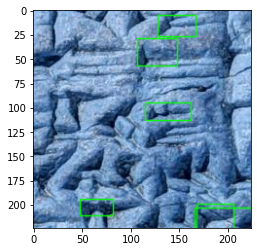

In [29]:
os.chdir(models_dir)
prediction_model = keras.models.load_model('SS_2000-0.7-55_TR_E100-SE100_VS-5_vgg_imagenet_OPT-adam_ES-True_AUG-False_224_full.h5')    # model_finale 
os.chdir(test_data_dir)
test_images = os.path.join(test_data_dir, validation_set_name)
threshold = 0.07
threshold_step_rate = 2
threshold_number_of_steps = 2
roboflow_index=0
allowed_occupation_rate = 0.5
z=0
discovered_duplicates = 0
for e,i in enumerate(os.listdir(test_images)):
    if i.endswith("jpg"):
        print("Found file: ", i)
        z += 1
        img = cv2.imread(os.path.join(test_images,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process() 
        imout = img.copy()
        region_index=0
        found_regions = [];
        helper = 0
        for step in range(threshold_number_of_steps):
            if(helper == threshold):
                print("NO NEED TO REPEAT EVALUATION PROCESS")
            else:
                helper = threshold
                for e,result in enumerate(ssresults):
                    if e < 2000:
                        x,y,w,h = result
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (image_edge_lenght,image_edge_lenght), interpolation = cv2.INTER_AREA)
                        img = np.expand_dims(resized, axis=0)
                        out= prediction_model.predict(img)
                        plotRectangle = plotRectangles(out, threshold, x, y, w, h, found_regions, allowed_occupation_rate)
                        if(plotRectangle == True):
                            print("I am plotting it")
                            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
                            region_index += 1
                            region = Region(x,y,w,h)
                            found_regions.append(region)
                        if(plotRectangle == False):
                            print("I am not plotting it")
                            discovered_duplicates +=  1
            if(len(found_regions)==0):
                threshold = threshold / threshold_step_rate 
        plt.figure()
        plt.imshow(imout)
        os.chdir(results_dir)
        cv2.imwrite(i, imout)
        new_name = str(roboflow_index) + "_" + str(region_index) + "_" + str(labels_in_images[roboflow_index]) + "_" + str(roboflow_order[roboflow_index]) + ".jpg"
        os.rename(i, new_name)
        os.chdir(test_data_dir)
        roboflow_index += 1
print("OPERATION FINISHED, PREVENTED DUCPLICATES: ", discovered_duplicates)

Found file:  proc_05-05_NBC11595_KWtif-R002-C003_png.rf.ff0ba015844b37b4c6f44f0c8ed5f938.jpg


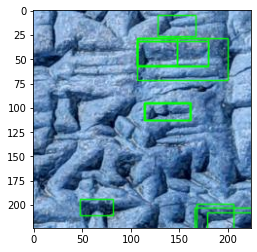

In [32]:
os.chdir(models_dir)
prediction_model = keras.models.load_model('SS_2000-0.7-55_TR_E100-SE100_VS-5_vgg_imagenet_OPT-adam_ES-True_AUG-False_224_full.h5')
os.chdir(test_data_dir)
test_images = "./224_one/"
z=0
for e,i in enumerate(os.listdir(test_images)):
    if i.endswith("jpg"):
        print("Found file: ", i)
        z += 1
        img = cv2.imread(os.path.join(test_images,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process() 
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (image_edge_lenght,image_edge_lenght), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= prediction_model.predict(img)
                #out= model_final.local(img)
                #print(out[0][0])
                if out[0][0] > 0.07:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        cv2.imwrite(i, imout)

In [ ]:
del model_final
del prediction_model